In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load data

# y_before: [# trials x # neurons] matrix of the activity of each neuron during the timestep just before stim
# y_after: [# trials x # neurons] matrix of the activity of each neuron during the timestep just after stim
# u: [# trials x # neurons] matrix of the photostim patterns in {0,1}

data = np.load('sample_photostim.npy',allow_pickle=True)
u = data.item()['u']
y_before = data.item()['y_before']
y_after = data.item()['y_after']
n,d = u.shape
print('(# trial, # neurons) =',u.shape)

indices = torch.randperm(n)
test_num = int(n * 0.2)
test_indices = indices[:test_num]
train_indices = indices[test_num:]

y_before_train = y_before[train_indices]
y_after_train = y_after[train_indices]
u_train = u[train_indices]
y_before_test = y_before[test_indices]
y_after_test = y_after[test_indices]
u_test = u[test_indices]

(# trial, # neurons) = (2308, 663)


## Train model

In [4]:
class LinearModel(nn.Module):
    def __init__(self, dim):
        super(LinearModel, self).__init__()  
        self.B = nn.Linear(dim, dim, bias=False)
        self.c = nn.Parameter( torch.randn(dim)  )
        self.beta = nn.Parameter( torch.randn(dim)*0.1  )
        self.gamma = nn.Parameter( torch.ones(dim)  )

    def forward(self, x, a):
        return self.beta + self.gamma * torch.sigmoid( self.B(a + x) + self.c)


X_train = torch.tensor(y_before_train.copy(), dtype=torch.float32)/1000 # scale by 1000 so that data is approximartely in [0,1]
A_train = torch.tensor(u_train.copy(), dtype=torch.float32)
y_train = torch.tensor(y_after_train.copy(), dtype=torch.float32)/1000

X_test = torch.tensor(y_before_test.copy(), dtype=torch.float32)/1000
A_test = torch.tensor(u_test.copy(), dtype=torch.float32)
y_test = torch.tensor(y_after_test.copy(), dtype=torch.float32)/1000

num_neurons = X_train.shape[1]
model = LinearModel(num_neurons)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

# 3. Training loop
num_epochs = 2000
for epoch in range(num_epochs):

    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train, A_train)
    loss = criterion(y_pred, y_train) #+ 0.0001*torch.linalg.norm(model.B.weight, 1)
    train_loss = loss.item()

    # Backward pass: Compute gradient of the loss with respect to model parameters
    loss.backward()
    optimizer.step()

    # Clamp the weights to be at least 0 -- assumes an excited neuron can't decrease other neuron's rate
    with torch.no_grad():  # Make sure to use no_grad to avoid affecting the computation graph
        model.B.weight.data.clamp_(min=0)

    model.eval()

    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_test, A_test)
    loss = criterion(y_pred, y_test)  
    test_loss = loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

Epoch [10/2000], Train Loss: 0.123073, Test Loss: 0.113524
Epoch [20/2000], Train Loss: 0.050577, Test Loss: 0.045857
Epoch [30/2000], Train Loss: 0.017737, Test Loss: 0.015880
Epoch [40/2000], Train Loss: 0.005724, Test Loss: 0.005138
Epoch [50/2000], Train Loss: 0.002065, Test Loss: 0.001911
Epoch [60/2000], Train Loss: 0.001012, Test Loss: 0.000981
Epoch [70/2000], Train Loss: 0.000710, Test Loss: 0.000713
Epoch [80/2000], Train Loss: 0.000590, Test Loss: 0.000604
Epoch [90/2000], Train Loss: 0.000519, Test Loss: 0.000536
Epoch [100/2000], Train Loss: 0.000479, Test Loss: 0.000499
Epoch [110/2000], Train Loss: 0.000453, Test Loss: 0.000474
Epoch [120/2000], Train Loss: 0.000433, Test Loss: 0.000455
Epoch [130/2000], Train Loss: 0.000418, Test Loss: 0.000440
Epoch [140/2000], Train Loss: 0.000405, Test Loss: 0.000427
Epoch [150/2000], Train Loss: 0.000395, Test Loss: 0.000417
Epoch [160/2000], Train Loss: 0.000385, Test Loss: 0.000408
Epoch [170/2000], Train Loss: 0.000377, Test Loss

Epoch [1380/2000], Train Loss: 0.000199, Test Loss: 0.000221
Epoch [1390/2000], Train Loss: 0.000199, Test Loss: 0.000221
Epoch [1400/2000], Train Loss: 0.000198, Test Loss: 0.000220
Epoch [1410/2000], Train Loss: 0.000198, Test Loss: 0.000220
Epoch [1420/2000], Train Loss: 0.000198, Test Loss: 0.000220
Epoch [1430/2000], Train Loss: 0.000197, Test Loss: 0.000219
Epoch [1440/2000], Train Loss: 0.000197, Test Loss: 0.000219
Epoch [1450/2000], Train Loss: 0.000196, Test Loss: 0.000218
Epoch [1460/2000], Train Loss: 0.000196, Test Loss: 0.000218
Epoch [1470/2000], Train Loss: 0.000196, Test Loss: 0.000218
Epoch [1480/2000], Train Loss: 0.000195, Test Loss: 0.000217
Epoch [1490/2000], Train Loss: 0.000195, Test Loss: 0.000217
Epoch [1500/2000], Train Loss: 0.000195, Test Loss: 0.000217
Epoch [1510/2000], Train Loss: 0.000194, Test Loss: 0.000216
Epoch [1520/2000], Train Loss: 0.000194, Test Loss: 0.000216
Epoch [1530/2000], Train Loss: 0.000193, Test Loss: 0.000216
Epoch [1540/2000], Train

## Original spiking plot

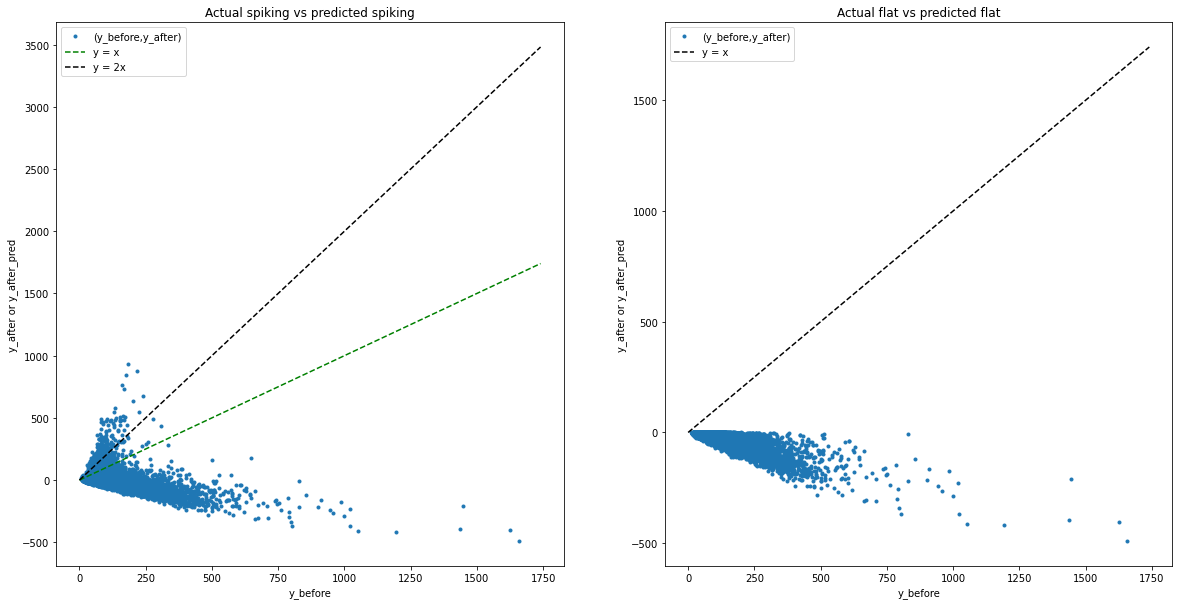

In [33]:
model.eval()
y_after_test_pred = model(X_test,A_test).detach().numpy()*1000

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
off_trials = (u_test==0)
gt_increase = np.divide(y_after_test,y_before_test)
spiked = (gt_increase >= -200.0)
eval_idx = np.logical_and(off_trials,spiked)
plt.plot(y_before_test[eval_idx],y_after_test[eval_idx] - y_before_test[eval_idx],'.',label='(y_before,y_after)')
#plt.plot(y_before_test[eval_idx],y_after_test_pred[eval_idx] - y_before_test[eval_idx],'.',label='(y_before,y_after_pred)')
plt.xlabel('y_before')
plt.ylabel('y_after or y_after_pred')
plt.title('Actual spiking vs predicted spiking')
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.plot([0,x_limits[1]],[0,x_limits[1]],'g--',label='y = x')
plt.plot([0,x_limits[1]],[0,2*x_limits[1]],'k--',label='y = 2x')
plt.legend()

plt.subplot(1,2,2)
not_spiked = (gt_increase <= 1.0)
eval_idx = np.logical_and(off_trials,not_spiked)
plt.plot(y_before_test[eval_idx],y_after_test[eval_idx] - y_before_test[eval_idx],'.',label='(y_before,y_after)')
#plt.plot(y_before_test[eval_idx],y_after_test_pred[eval_idx] - y_before_test[eval_idx],'.',label='(y_before,y_after_pred)')
plt.xlabel('y_before')
plt.ylabel('y_after or y_after_pred')
plt.title('Actual flat vs predicted flat')
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.plot([0,x_limits[1]],[0,x_limits[1]],'k--',label='y = x')
plt.legend()

## Normalized spiking plot

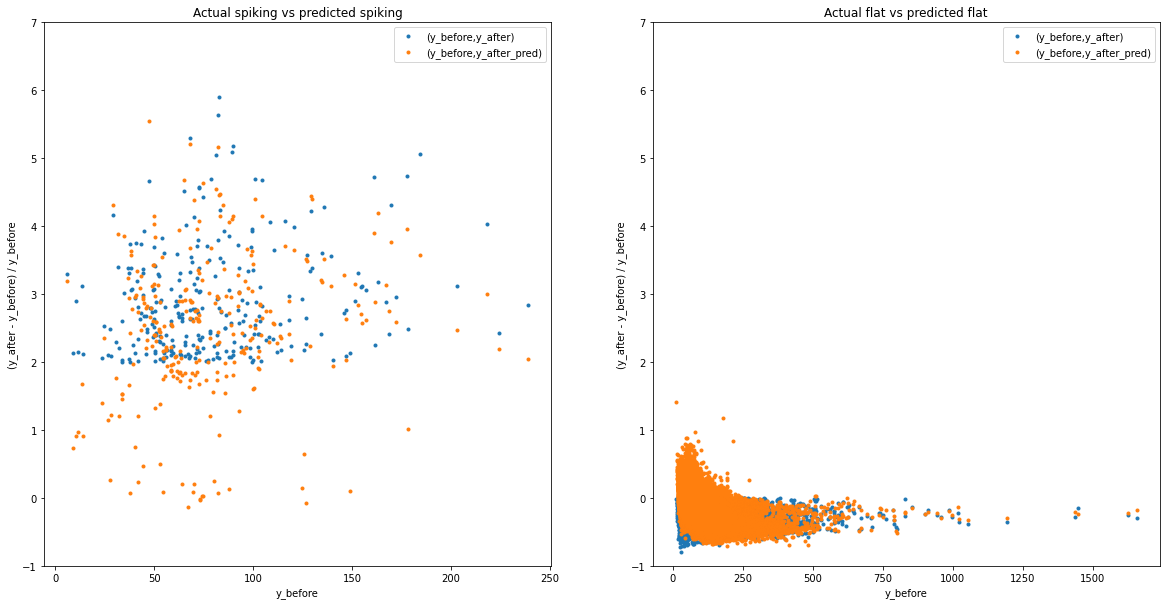

In [28]:
model.eval()
y_after_test_pred = model(X_test,A_test).detach().numpy()*1000

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
off_trials = (u_test==0)
gt_increase = np.divide(y_after_test-y_before_test,y_before_test)
spiked = (gt_increase >= 2.0)
eval_idx = np.logical_and(off_trials,spiked)
spike_true = np.divide(y_after_test[eval_idx] - y_before_test[eval_idx], y_before_test[eval_idx])
plt.plot(y_before_test[eval_idx],spike_true,'.',label='(y_before,y_after)')
spike_pred = np.divide(y_after_test_pred[eval_idx] - y_before_test[eval_idx], y_before_test[eval_idx])
plt.plot(y_before_test[eval_idx],spike_pred,'.',label='(y_before,y_after_pred)')
plt.xlabel('y_before')
plt.ylabel('(y_after - y_before) / y_before')
plt.title('Actual spiking vs predicted spiking')
plt.ylim([-1,7])
plt.legend()

plt.subplot(1,2,2)
not_spiked = (gt_increase <= 0.0)
eval_idx = np.logical_and(off_trials,not_spiked)
spike_true = np.divide(y_after_test[eval_idx] - y_before_test[eval_idx], y_before_test[eval_idx])
plt.plot(y_before_test[eval_idx],spike_true,'.',label='(y_before,y_after)')
spike_pred = np.divide(y_after_test_pred[eval_idx] - y_before_test[eval_idx], y_before_test[eval_idx])
plt.plot(y_before_test[eval_idx],spike_pred,'.',label='(y_before,y_after_pred)')
plt.xlabel('y_before')
plt.ylabel('(y_after - y_before) / y_before')
plt.title('Actual flat vs predicted flat')
plt.ylim([-1,7])
plt.legend()

## Learned connectivity graph

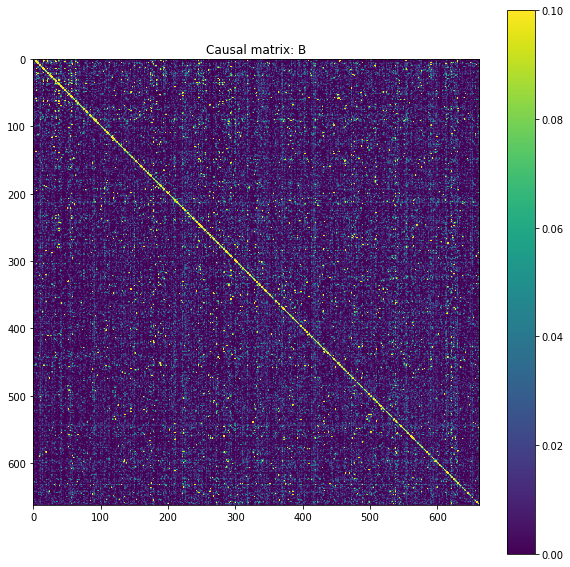

In [21]:
B = model.B.weight.detach().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(B, norm=colors.Normalize(vmin=0.0, vmax=.1))
plt.colorbar()
plt.title('Causal matrix: B')
plt.show()

## Generate ROC curves

In [22]:
# evaluation function
def evaluate(model,X_test,A_test,u_test,excluded_neurons=None,thresholds=[2.0,1.25,1,1.1],normalized=False):
    model.eval()
    y_after_test_pred = model(X_test,A_test).detach().numpy()*1000
    off_trials = (u_test==0)
    if normalized:
        gt_increase = np.divide(y_after_test-y_before_test,y_before_test)
    else:
        gt_increase = np.divide(y_after_test,y_before_test)
    spiked = (gt_increase >= thresholds[0])    
    eval_idx = np.logical_and(off_trials,spiked)
    if excluded_neurons is not None:
        off_trials[:,excluded_neurons] = False
    error = np.linalg.norm(y_after_test_pred[eval_idx] - y_after_test[eval_idx], 2)**2 / np.sum(eval_idx)
    if normalized:
        pred_increase = np.divide(y_after_test_pred-y_before_test,y_before_test)
    else:
        pred_increase = np.divide(y_after_test_pred,y_before_test)
    spiked_pred = (pred_increase >= thresholds[1])
    correct_rate = np.sum(np.logical_and(spiked_pred[off_trials],spiked[off_trials])) / np.sum(spiked[off_trials])
    incorrect_rate = np.sum(np.logical_and(spiked_pred[off_trials],spiked[off_trials])) / np.sum(spiked[off_trials])

    not_spiked = (gt_increase <= thresholds[2])
    not_spiked_pred = (pred_increase <= thresholds[3])
    correct_rate_not = np.sum(np.logical_and(not_spiked_pred[off_trials],not_spiked[off_trials])) / np.sum(not_spiked[off_trials])
    return error, correct_rate, correct_rate_not

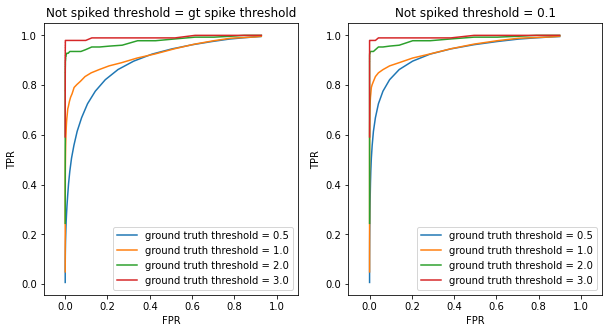

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
thresholds = [2.0,1.25,2.0,1.1]
# thresholds_spike = np.linspace(0.5,4.1,100)
# thresholds_gt_spike = [1.5,2.0,3.0,4.0]
thresholds_spike = np.linspace(-0.2,3.1,100)
thresholds_gt_spike = [0.5,1.0,2.0,3.0]

for t_gt in thresholds_gt_spike:
    tpr = []
    fpr = []
    thresholds[0] = t_gt
    thresholds[2] = t_gt
    for t in range(len(thresholds_spike)):
        thresholds[1] = thresholds_spike[t]
        thresholds[3] = thresholds_spike[t]
        _, correct_spiked, correct_flat = evaluate(model,X_test,A_test,u_test,thresholds=thresholds,normalized=True)
        tpr.append(correct_spiked)
        fpr.append(1 - correct_flat)

    plt.plot(fpr,tpr,label='ground truth threshold = ' + str(t_gt))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Not spiked threshold = gt spike threshold')
plt.xlim([-0.1,1.1])
plt.legend()


plt.subplot(1,2,2)
thresholds = [2.0,1.25,0.1,1.1]

for t_gt in thresholds_gt_spike:
    tpr = []
    fpr = []
    thresholds[0] = t_gt
    for t in range(len(thresholds_spike)):
        thresholds[1] = thresholds_spike[t]
        thresholds[3] = thresholds_spike[t]
        _, correct_spiked, correct_flat = evaluate(model,X_test,A_test,u_test,thresholds=thresholds,normalized=True)
        tpr.append(correct_spiked)
        fpr.append(1 - correct_flat)

    plt.plot(fpr,tpr,label='ground truth threshold = ' + str(t_gt))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Not spiked threshold = 0.1')
plt.xlim([-0.1,1.1])
plt.legend()
plt.show()

## Neuron spiking histogram

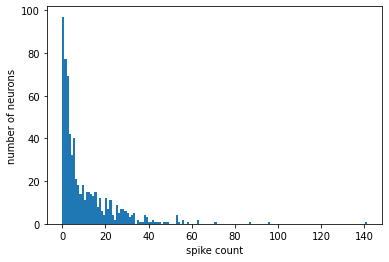

0.8536953242835595
0.521870286576169


In [27]:
off_trials = (u==0)
gt_increase = np.divide(y_after,y_before)
spiked = (gt_increase >= 2.0)    
eval_idx = np.logical_and(off_trials,spiked)
total_spikes = np.sum(eval_idx,axis=0)

plt.hist(total_spikes,bins=np.max(total_spikes)+1)
plt.ylabel('number of neurons')
plt.xlabel('spike count')
plt.show()

print(np.sum(total_spikes >= 1) / total_spikes.shape[0])
print(np.sum(total_spikes >= 5) / total_spikes.shape[0])

Text(0, 0.5, 'average mse')

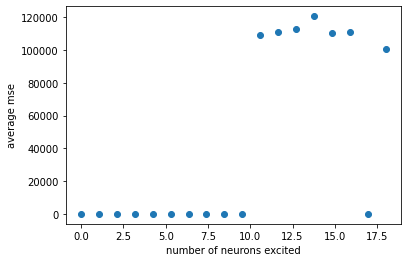

In [37]:
model.eval()
y_after_test_pred2 = model(X_test,A_test).detach().numpy()*1000
y_after_test_pred2[u_test==1] = 0
y_after_test2 = y_after_test
y_after_test2[u_test==1] = 0

n_test = u_test.shape[0]
#print(u_test.shape)
excited = np.sum(u_test, axis=1)
#plt.hist(excited,bins=100)
#plt.fig()
avg_mse = np.zeros(int(np.max(np.sum(u_test, axis=1)))+1)
counts = np.zeros(int(np.max(np.sum(u_test, axis=1)))+1)
for i in range(n_test):
    idx = int(excited[i])
    mse_i = np.linalg.norm(y_after_test_pred2[i,:] - y_after_test2[i,:], 2)**2
    avg_mse[idx] += mse_i
    counts[idx] += 1
for i in range(len(counts)):
    if counts[i] > 0:
        avg_mse[i] = avg_mse[i] / counts[i]
        
plt.scatter(np.linspace(0,len(counts),len(counts)),avg_mse)
plt.xlabel('number of neurons excited')
plt.ylabel('average mse')

In [9]:
model.eval()
y_after_test_pred = model(X_test,A_test).detach().numpy()*1000
off_trials = (u_test==0)
err_tot = np.linalg.norm(y_after_test_pred[off_trials] - y_after_test[off_trials],2)**2
var = np.linalg.norm(y_after_test[off_trials] - np.mean(y_after_test[off_trials]),2)**2
fvu = err_tot / var
r_squared = 1 - fvu
print('fvu = ' + str(fvu))
print('R^2 = ' + str(r_squared))

fvu = 0.1658814740391372
$R^2$ = 0.8341185259608628


(461, 663)
(461, 663)


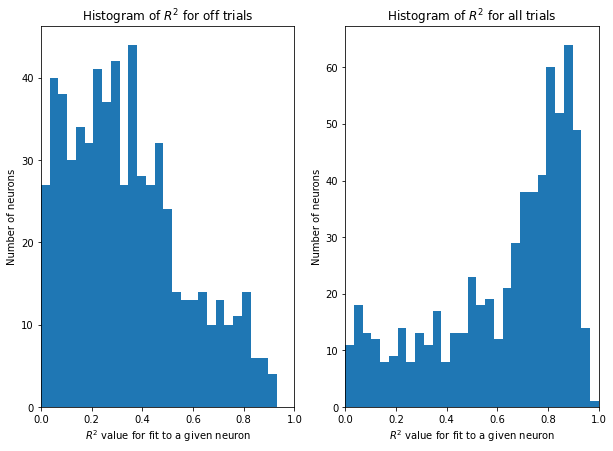

In [44]:
model.eval()
off_trials = (u_test==0)
y_after_test_pred = model(X_test,A_test).detach().numpy()*1000
print(y_after_test_pred.shape)
print(off_trials.shape)
R_sq = np.zeros(off_trials.shape[1])
mean_tot = np.mean(y_after_test[off_trials])
mean_vals = np.zeros(off_trials.shape[1])
#off_trials = np.ones(off_trials.shape).astype(int)
for i in range(off_trials.shape[1]):
    y_pred_i = np.zeros(np.sum(off_trials[:,i]))
    y_true_i = np.zeros(np.sum(off_trials[:,i]))
    idx = 0
    for j in range(off_trials.shape[0]):
        if off_trials[j,i] == 1:
            y_pred_i[idx] = y_after_test_pred[j,i]
            y_true_i[idx] = y_after_test[j,i]
            idx += 1
    R_sq[i] = 1 - np.linalg.norm(y_pred_i - y_true_i,2)**2 / np.linalg.norm(y_true_i - np.mean(y_true_i),2)**2
    #R_sq[i] = 1 - np.linalg.norm(y_after_test[off_trials[:,i],i]-y_after_test_pred[off_trials[:,i],i],2)**2/np.linalg.norm(y_after_test[off_trials[:,i],i]-np.mean(y_after_test[off_trials[:,i],i]),2)**2
    #R_sq[i] = 1 - np.linalg.norm(y_after_test[off_trials[:,i],i]-y_after_test_pred[off_trials[:,i],i],2)**2/np.linalg.norm(y_after_test[off_trials[:,i],i]-mean_tot,2)**2
    
R_sq2 = 1 - np.sum( (y_after_test-y_after_test_pred)**2,axis=0)/np.sum( (y_after_test-np.mean(y_after_test,axis=0))**2,axis=0)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.hist(R_sq,np.linspace(0,1,30))
plt.title('Histogram of $R^2$ for off trials')
plt.xlabel('$R^2$ value for fit to a given neuron')
plt.ylabel('Number of neurons')
plt.xlim([0,1])
plt.subplot(1,2,2)
#plt.hist(mean_vals)
#print(mean_tot)
plt.hist(R_sq2,np.linspace(0,1,30))
plt.title('Histogram of $R^2$ for all trials')
plt.xlabel('$R^2$ value for fit to a given neuron')
plt.ylabel('Number of neurons')
plt.xlim([0,1])
plt.show()

In [16]:
data = np.load('sample_photostim_0113.npy', allow_pickle = True).item()
y = data['y']
u = data['u']
num_trials = y.shape[0]
num_steps = y.shape[1]
num_neurons = y.shape[2]
T_before = 4
T_after_start = 9
T_after_end = 13
y_before = np.mean(y[:,:T_before,:],axis = 1)
y_after = np.mean(y[:,T_after_start:T_after_end,:],axis = 1)

y_session = data['y_session']
u_session = data['u_session']

print(y_session.shape)
print(y[0,:,0])
for i in range(100):
    if np.sum(u_session[0:100,i]) > 0:
        print(u_session[85:100,i])
        print(y_session[85:100,i])
        break
#print(u_session[0:100,2])

(33698, 663)
[ 89.21409607  99.31386566  87.81181335 111.31936646  82.16053772
          nan          nan          nan 133.25274658 134.39677429
  89.61518097  76.35661316  91.36611176  86.11981964 133.11141968
  98.24053192]
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[      nan       nan       nan 297.07504 289.2288  211.26265 212.94191
 211.71893 224.96342 160.32037 199.28912 174.51804 159.98695 209.07042
       nan]
